In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("two_way_repeated.csv")
df.head()

,id,treatment,time,score
0,1,ctr,t1,83
1,2,ctr,t1,97
2,3,ctr,t1,93
3,4,ctr,t1,92
4,5,ctr,t1,77


## Summary Statistics

In [3]:
stats = df.groupby(['treatment', 'time'])['score'].agg(['count', 'std', 'mean'])
stats

count        std       mean
treatment time                             
Diet      t1       12   7.621242  87.583333
          t2       12   7.420283  87.833333
          t3       12   8.138945  87.666667
ctr       t1       12   8.079154  88.000000
          t2       12  10.232154  83.833333
          t3       12  10.542842  78.666667

## Boxplot

<AxesSubplot:xlabel='time', ylabel='score'>

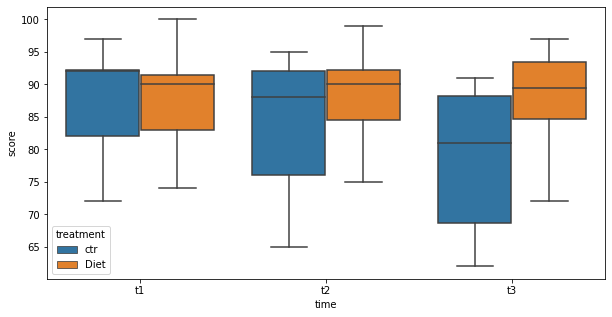

In [4]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='time', y='score', hue='treatment', data=df, linewidth=1.5)

## Interaction plot using Seaborn

<AxesSubplot:xlabel='time', ylabel='score'>

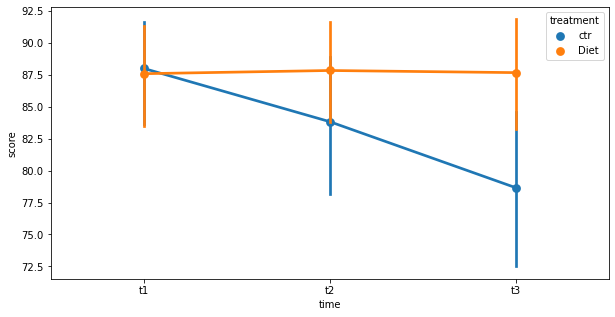

In [5]:
plt.figure(figsize=(10, 5))
ax = sns.pointplot(x='time', y='score', hue='treatment', data=df)
ax

# Assumptions

### Outliers

In [6]:
def outliers(dep, ind1, ind2):
    dicts = {'Outliers':{}}
    for cat_ind1 in pd.unique(df[ind1]):
        for cat_ind2 in pd.unique(df[ind2]):
            Q1, Q3 = np.percentile(df[dep][df[ind1] == cat_ind1][df[ind2] == cat_ind2], [25,75])
            IQR = Q3-Q1
            lower_fence, upper_fence= Q1-(1.5*IQR), Q3+(1.5*IQR)
            new_dataset = []
            for i in df[dep][df[ind1] == cat_ind1][df[ind2] == cat_ind2]:
                if i < lower_fence or i > upper_fence:
                    new_dataset.append(i)
            dicts['Outliers'][f'{cat_ind1} and {cat_ind2}'] = new_dataset
    return pd.DataFrame(dicts)

In [7]:
outliers('score', 'time', 'treatment')

,Outliers
t1 and Diet,[]
t1 and ctr,[]
t2 and Diet,[]
t2 and ctr,[]
t3 and Diet,[]
t3 and ctr,[]


### Normality

In [8]:
def shapiro(dep, ind1, ind2):
    normality = {'Shapiro':{}}
    import scipy.stats as stats
    for cat_ind1 in pd.unique(df[ind1]):
        for cat_ind2 in pd.unique(df[ind2]):
            result = stats.shapiro(df[dep][df[ind1] == cat_ind1][df[ind2] == cat_ind2])
            normality['Shapiro'][f'{cat_ind1} and {cat_ind2}'] = result
    return pd.DataFrame(normality)

In [9]:
shapiro('score', 'time', 'treatment')

,Shapiro
t1 and Diet,"(0.9191142320632935, 0.27866238355636597)"
t1 and ctr,"(0.8282107710838318, 0.019966181367635727)"
t2 and Diet,"(0.9234678149223328, 0.3159623146057129)"
t2 and ctr,"(0.8681047558784485, 0.06183488667011261)"
t3 and Diet,"(0.8858128786087036, 0.10407914966344833)"
t3 and ctr,"(0.8868127465248108, 0.10720895975828171)"


## Two-Way ANOVA Computation

In [10]:
import pingouin as pg
aov = pg.rm_anova(dv='score', within=['treatment', 'time'], subject='id', data=df, detailed=True)
aov.round(2)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,treatment,316.68,1,11,316.68,15.54,0.0,0.0,0.59,1.00
1,time,258.69,2,22,129.35,27.37,0.0,0.0,0.71,0.65
2,treatment * time,266.36,2,22,133.18,30.42,0.0,0.0,0.73,0.72


## Post-hoct tests

### Procedure for significant two-way interaction

#### Compute simple main effects

In [11]:
# Effect of treatment at each time point

In [12]:
t1 = df[df['time'] == 't1']
t2 = df[df['time'] == 't2']
t3 = df[df['time'] == 't3']

In [13]:
pg.rm_anova(dv="score", within='treatment', subject='id', data=t2).round(3)

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,treatment,1,11,9.026,0.012,0.451,1.0


In [14]:
pg.rm_anova(dv="score", within='treatment', subject='id', data=t2).round(3)

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,treatment,1,11,9.026,0.012,0.451,1.0


In [15]:
pg.rm_anova(dv="score", within='treatment', subject='id', data=t3).round(3)

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,treatment,1,11,30.902,0.0,0.737,1.0


#### Compute simple main effects

In [16]:
# Effect of time at each level of treatment

In [17]:
ctr = df[df['treatment'] == 'ctr']
Diet = df[df['treatment'] == 'Diet']

In [18]:
pg.rm_anova(dv="score", within='time', subject='id', data=ctr).round(3)

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,time,2,22,39.711,0.0,0.783,0.693


In [19]:
pg.rm_anova(dv="score", within='time', subject='id', data=Diet).round(3)

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,time,2,22,0.078,0.925,0.007,0.71


#### Compute pairwise comparisons

In [20]:
# Pairwise comparisons between treatment groups

In [21]:
t1 = df[df['time'] == 't1']
t2 = df[df['time'] == 't2']
t3 = df[df['time'] == 't3']

In [22]:
pg.pairwise_ttests(dv='score', within=['treatment'], subject='id',  padjust='bonf', data=t1).round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,treatment,Diet,ctr,True,True,-0.613,11.0,two-sided,0.552,0.338,-0.051


In [23]:
pg.pairwise_ttests(dv='score', within=['treatment'], subject='id',  padjust='bonf', data=t2).round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,treatment,Diet,ctr,True,True,3.004,11.0,two-sided,0.012,5.11,0.432


In [24]:
pg.pairwise_ttests(dv='score', within=['treatment'], subject='id',  padjust='bonf', data=t3).round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,treatment,Diet,ctr,True,True,5.559,11.0,two-sided,0.0,181.839,0.923


#### Compute pairwise comparisons

In [25]:
# Pairwise comparisons between treatment points

In [26]:
pg.pairwise_ttests(dv='score', within=['time', 'treatment'], subject='id',  padjust='bonf', data=df).round(3)

,Contrast,time,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,time,-,t1,t2,True,True,4.352,11.0,two-sided,0.001,0.003,bonf,35.556,0.230
1,time,-,t1,t3,True,True,5.631,11.0,two-sided,0.000,0.000,bonf,199.418,0.532
2,time,-,t2,t3,True,True,4.834,11.0,two-sided,0.001,0.002,bonf,69.395,0.292
3,treatment,-,Diet,ctr,True,True,3.942,11.0,two-sided,0.002,NaN,NaN,19.857,0.472
4,time * treatment,t1,Diet,ctr,True,True,-0.613,11.0,two-sided,0.552,1.000,bonf,0.338,-0.051
5,time * treatment,t2,Diet,ctr,True,True,3.004,11.0,two-sided,0.012,0.036,bonf,5.11,0.432
6,time * treatment,t3,Diet,ctr,True,True,5.559,11.0,two-sided,0.000,0.001,bonf,181.839,0.923


#### Compute pairwise comparisons

In [27]:
# Pairwise comparisons between time points

In [28]:
pg.pairwise_ttests(dv='score', within=['treatment', 'time'], subject='id',  padjust='bonf', data=df).round(3)

,Contrast,treatment,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,treatment,-,Diet,ctr,True,True,3.942,11.0,two-sided,0.002,NaN,NaN,19.857,0.472
1,time,-,t1,t2,True,True,4.352,11.0,two-sided,0.001,0.003,bonf,35.556,0.230
2,time,-,t1,t3,True,True,5.631,11.0,two-sided,0.000,0.000,bonf,199.418,0.532
3,time,-,t2,t3,True,True,4.834,11.0,two-sided,0.001,0.002,bonf,69.395,0.292
4,treatment * time,Diet,t1,t2,True,True,-0.522,11.0,two-sided,0.612,1.000,bonf,0.323,-0.032
5,treatment * time,Diet,t1,t3,True,True,-0.102,11.0,two-sided,0.921,1.000,bonf,0.289,-0.010
6,treatment * time,Diet,t2,t3,True,True,0.283,11.0,two-sided,0.782,1.000,bonf,0.298,0.021
7,treatment * time,ctr,t1,t2,True,True,4.530,11.0,two-sided,0.001,0.005,bonf,45.632,0.436
8,treatment * time,ctr,t1,t3,True,True,6.912,11.0,two-sided,0.000,0.000,bonf,949.978,0.959
9,treatment * time,ctr,t2,t3,True,True,6.490,11.0,two-sided,0.000,0.000,bonf,578.555,0.480


### Procedure for non-significant two-way interaction

In [29]:
# comparisons for time variable

In [30]:
df.pairwise_ttests(dv='score', within=['time'], subject='id', padjust='bonf').round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,time,t1,t2,True,True,4.352,11.0,two-sided,0.001,0.003,bonf,35.556,0.230
1,time,t1,t3,True,True,5.631,11.0,two-sided,0.000,0.000,bonf,199.418,0.532
2,time,t2,t3,True,True,4.834,11.0,two-sided,0.001,0.002,bonf,69.395,0.292


In [31]:
# comparisons for treatment variable

In [32]:
df.pairwise_ttests(dv='score', within=['treatment'], subject='id',   padjust='bonf').round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,treatment,Diet,ctr,True,True,3.942,11.0,two-sided,0.002,19.857,0.472


#### Compute pairwise comparisons

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

t2_ctr vs. t2_Diet: Custom statistical test, P_val:3.600e-02
t1_ctr vs. t1_Diet: Custom statistical test, P_val:1.000e+00
t3_ctr vs. t3_Diet: Custom statistical test, P_val:1.000e-03


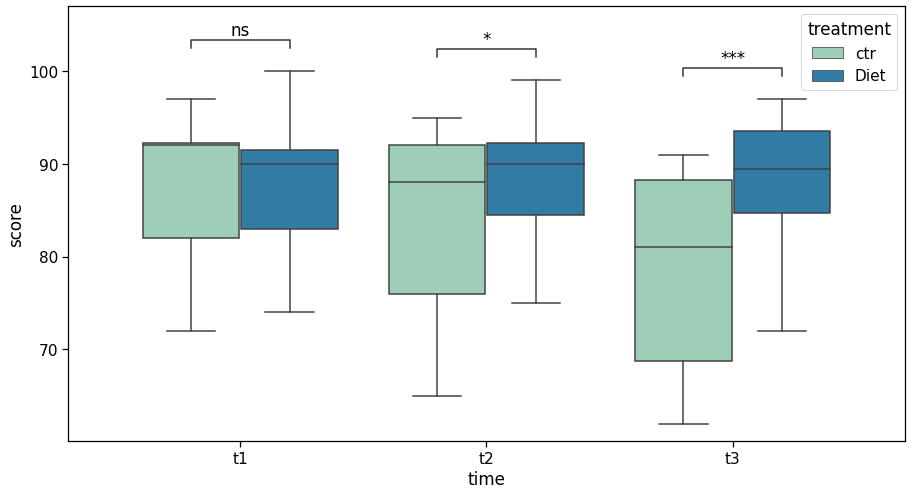

In [33]:
from statannotations.Annotator import Annotator

subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=3)
subcat_palette = sns.color_palette("YlGnBu", n_colors=2)

treatment_order = ["ctr", "Diet"]
time = ['t1', 't2', 't3']

pvalues = [1, 0.036, 0.001]
# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls..

pairs = [
    [('t1', 'ctr'), ('t1', 'Diet')],
    [('t2', 'ctr'), ('t2', 'Diet')],
    [('t3', 'ctr'), ('t3', 'Diet')],
]

plotting_parameters = {
    'data': df,
    'x': 'time',
    'y': 'score',
    "order": time,
    "hue": "treatment",
    "hue_order": treatment_order,
    "palette": subcat_palette
}

formatted_pvalues = [f"p={p:.2e}" for p in pvalues]
with sns.plotting_context('notebook', font_scale = 1.4):

    from matplotlib import pyplot as plt
    plt.figure(figsize=(15,8))
    # Plot with seaborn
    ax = sns.boxplot(**plotting_parameters)

    # Add annotations
    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.set_pvalues(pvalues)
    annotator.annotate()

    plt.show()